# 사전 학습된 네트워크를 일부 조정하여 모델 훈련시키기
## 1. VGG16 모델 조정
- VGG16은 ImageNet dataset에서 훈련된 합성곱 기반 네트워크로 케라스에 패키지로 포함되어 있다.
- 사전 학습된 모델의 완전 분류기(최상위 Dense 층)는 표현이 일반적이지 않기 때문에 재사용하기 어렵다. 그보다 상대적으로 더 하위 레벨의 합성곱 층들은 이미지의 질감, 색상 등의 더 일반적인 특성을 판단하므로 상대적으로 더 많은 문제에 사용하기 적합하므로 최상위 완전 분류기를 제외한 이 부분만 사용한다.

In [3]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150,3))

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

- 사전 학습된 모델은 여러 개의 층으로 이루어져 있는데, 이중 일부 상위 층을 동결하지 않고 모델에 연결하는 방식을 활용하면 사전 학습된 모델이 추가적으로 일부 학습되는 과정에서 미세하게 조정되어 현재 해결하려는 문제에 더 밀접하게 연관되도록 할 수 있다.
- 여기선 가장 상위 합성곱 기반 층인 block5에 속한 합성곱 층들을 가중치 업데이트가 가능하도록 두고 나머지 층들은 동결한다. 

In [5]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

## 2. 모델 구성 및 훈련
- 앞서 일부 층을 동결한 conv_base 모델을 활용하여 이미지 이진 분류 모델을 만들고 학습한다. 훈련 과정에서 conv_base에 속한 일부 상위 층들의 가중치 파라미터가 최신화되며 문제 해결에 더 적합한 방향으로 조정된다.
- Overfitting을 제한하기 위해 ImageDataGenerator를 이용하여 훈련 이미지를 증식하여 학습시킨다.

In [6]:
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [8]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './datasets/small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-5), metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 31s 301ms/step - loss: 0.3889 - acc: 0.8365 - val_loss: 0.2697 - val_acc: 0.8820
Epoch 2/100
100/100 [==============================] - 28s 281ms/step - loss: 0.2826 - acc: 0.8825 - val_loss: 0.2267 - val_acc: 0.9020
Epoch 3/100
100/100 [==============================] - 26s 264ms/step - loss: 0.2236 - acc: 0.9115 - val_loss: 0.2090 - val_acc: 0.9060
Epoch 4/100
100/100 [==============================] - 27s 265ms/step - loss: 0.1898 - acc: 0.9215 - val_loss: 0.2005 - val_acc: 0.9140
Epoch 5/100
100/100 [==============================] - 27s 264ms/step - loss: 0.1858 - acc: 0.9310 - val_loss: 0.2006 - val_acc: 0.9150
Epoch 6/100
100/100 [==============================] - 27s 271ms/step - loss: 0.1576 - acc: 0.9375 - val_loss: 0.2071 - val_acc: 0.9130
Epoch 7/100
100/100 [==============================] - 30s 300ms/step - loss: 0.1517 - acc: 0.9370 -

## 3. 학습 결과 분석
- 학습 결과를 그래프로 분석해본 결과 변동이 너무 심해 알아보기가 다소 어렵다.
- 지수 이동 평균을 사용하여 그래프를 부드럽게 만들어서 결과를 확인한다.

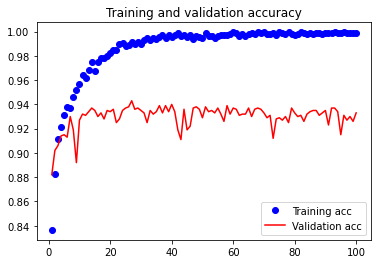

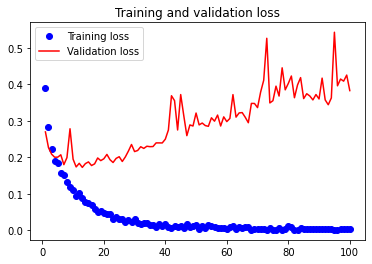

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

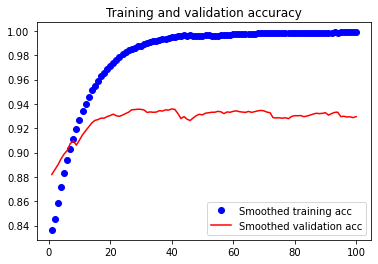

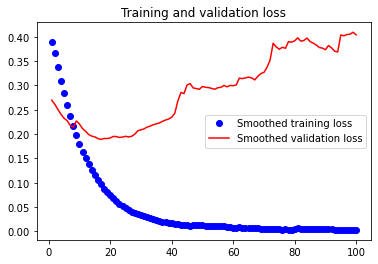

In [10]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'r', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'r', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- 분석 결과 정확도는 향상되었지만 손실은 다소 악화되었다. 그 이유는 손실 그래프가 각각의 손실 값들의 평균을 그린 것이기 때문에, 실제 정확도에 영향을 직접적으로 미치는 손실 값의 분포 양상과는 다소 다른 모양을 그릴 수 있기 때문이다.
- 마지막으로 테스트 데이터를 활용하여 모델을 평가하고, 향후 작업을 위해 모델을 저장한다.

In [17]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150,150),batch_size=20,class_mode='binary')
test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('Test accuracy: %.2f%%' % (test_acc * 100))

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 8s 148ms/step - loss: 0.3489 - acc: 0.9420
Test accuracy: 94.20%


In [15]:
import numpy as np

def save_model(model, history, num=1):
    model.save('cats_and_dogs_small_%d.h5' % num)
    np.save('cats_and_dogs_history_%d.npy' % num,history.history)

save_model(model, history, num=4)

- 테스트 결과 약 94% 이상의 정확도를 얻었다. 원래 캐글 경연에서도 꽤 높은 결과이며, 전체 20,000개의 데이터 중 약 10%만 활용해서 얻은 결과라는 점에 큰 의미가 있다고 할 수 있다.